# ISEL - Aprendizagem Automática(AA)
## Semestre de Inverno 2025/26
# <br>
###  <center> Trabalho Prático 1 </center>
###  <center> Incidência de diabetes em índios Pima </center>

# </br>

Trabalho realizado por:
* <b>Ruben Zhang, número 51388 </b>
* <b>Sofia Salgado, número 51694 </b>
* <b>Lucas Filipe , número 51793 </b>


<b> Turma 51D - Docente: Gonçalo Marques </b>

## Apontamentos das Aulas

Dentro da inteligência artificial existe a aprendizagem automática, machine learning

<div align="center">
    <img src="https://tse3.mm.bing.net/th/id/OIP.hRNpkhGN2HL2rFcc2vFYwAHaFj?r=0&rs=1&pid=ImgDetMain&o=7&rm=3" alt="Imagem 1" width="25%">
</div>


O problema XOR é que não conseguimos desenhar uma linha reta para separar os pontos positivos ((1,0) e (0,1)) dos negativos ((0,0) e (1,1)) - eles estão "entrelaçados" nos cantos opostos.

As redes neuronais ficaram relativamente para trás por serem dificeis de treinar, mas entretanto, recentemente, voltaram.

#### Existem diferentes tipos de aprendizagem:

`Supervisionada: `O computador aprende com exemplos que já têm as respostas certas - **Classificação** (decidir se um email é spam ou não) e **Regressão** (prever preços de casas como no Boston House Prices dataset). <br>
`Não Supervisionada:` O computador procura padrões sem saber as respostas - agrupar dados parecidos e simplificar dados complexos. <br>
`Semi-Supervisionada:` Mistura das duas anteriores - alguns dados têm rótulos, outros não. <br>
`Reforço:` Os agentes aprendem ao interagir com um ambiente e a receber recompensas - como é feito nos jogos.

<div align="center">
    <img src="https://tse3.mm.bing.net/th/id/OIP.0Nrd1PSXFYPVSzkAuIMNZgHaGp?r=0&rs=1&pid=ImgDetMain&o=7&rm=3" alt="Imagem 1" width="20%">
    <img src="https://www.pngall.com/wp-content/uploads/11/Horizontal-Line-PNG-Pic.png" alt="Imagem 2" width="20%">
</div>
    

Os dados podem ser espalhados em 2D, imagem da esquerda, mas também posso esticar a espiral e meter os dados espalhados em 1D, como é o caso da imagem à direita

Nós queremos treinar o modelo com um conjunto universal para todos os dados que vêm a seguir.

Convém sempre nós olharmos também para os dados, pois algumas vezes conseguimos distinguir os dados a olho.

Aqueles dados que já sabemos a classe utilizamos para treinar o modelo. Não vamos classificar classes que já sabemos.

### Sistemas de Classificação

Nós não estamos interessados em saber as classes dos dados, aqueles que já sabemos a classe utilizamos para treinar, não vamos classificar classes que já sabemos. Convém nós olharmos para os dados, porque algumas vezes conseguimos distinguir bem os dados. Queremos treinar com um conjunto de dados universal para todos os dados que vêm a seguir. 

A construção do modelo de classificação é baseado num conjunto de dados para os quais se conhece a classe, e é composta pelas seguintes etapas: 
- 1: Escolher/projetar o modelo de classificação
- 2: Treinar o modelo
- 3: Avaliar o modelo

Este é um problema de aprendizagem supervisionada, os classificadores são treinados com exemplo para os quais já se sabe a classe.

Tipos de Classificação:
- Multi-Classe
- Binária
- Multi-Label

### Enquadramento Teórico e Notação

Cada vetor representa uma classe e todos os vetores devem ter a mesma dimensão. <br>
Dividir o espaço em zonas, regiões de decisão, é uma hipótese para classificar os dados, temos os pontos no espaço e depois dividimos em zonas as classes, por exemplo classe 0 fica numa zona, classe 1 noutra, etc... <br>
Mas o que realmente vamos fazer é através de funções discriminantes, pomos a função `Gause` em cada uma das classes

### Matriz de Confusão:

É uma matriz quadrada, ou seja, se temos 10 classes a matriz é $ 10\times10 $ <br>
A matriz é composta só por probabilidade, pois cada classe tem probabilidades. 

Se somar todos os valores na matriz de confusão tem de dar 1, 100%, tenho todos os pontos na matriz.

$A_{3 \times 4}$

$$A = \begin{bmatrix}
-8 & 1 & 5 & -4 & -1 \\
20 & 0 & -9 & 4 & -9 \\
-25 & 0 & 3 & 0 & 11
\end{bmatrix}$$




Temos de analisar o tipo de erros que estamos a ter, se o classificador, por exemplo, está a confundir malas com saias ou com calças, alguma coisa está mal.

A matriz de confusão não nos diz a probabilidade total de erro, faltam as probabilidades à priori de cada classe:

Probabilidade total de erro:
$$ \sum_{i}{} (1-p_i) \times p(w_i) $$

A matriz de confusão do scikit-learn é não normalizada, onde somamos as linhas e temos todos os pontos de uma classe.

### ====== Classificação Binária ======

Chamam-se às duas classes positivos e negativos ($w_p, w_n$) e os que nos interessam são os positivos. O que eu não quero são os falsos positivos e na medicina o que não quero são os falsos negativos.

#### Métricas de desempenho - Classificação Binária

Se somar a primeira linha da matriz tenho o número total de exemplos positivos e se somar a segunda linha da matriz tenho o número total de exemplos negativos.

$$ Recall = \frac {TP}{TP + FN} $$

$$ Precision = \frac {TP}{TP+FP} $$

Para classificadores binários podemos calibrá-lo, ou seja, tornar o classificador mais conservador, só diz que é positivo raramente ou se tiver mesmo a certeza da sua resposta, ou liberal, é positivo maior parte das vezes. <br>
Assim é mais fácil meter o Recall a 1 e a Precision igual a 1, mas os dois ao mesmo tempo é mais dificil.

#### Curvas de ROC

Com as curvas de ROC temos uma ideia melhor de como o classificador está a comportar-se

Os classificadores na diagonal das curvas de ROC não servem para nada, são para descartar, os classificadores no canto inferior direito estão a falhar mais que o aleatório, logo é só inverter o pensamento do classificador

Temos uma função e se essa função for maior que um linear então é da classe dos positivos, senão é da classe dos negativos. Onde meter este linear depende do contexto.

Estas curvas são ferramentas fundamentais para ver como o classificador está a comportar-se.

#### ====== Validação Cruzada ======

Em vez de dividir por 2 os dados, vamos cortar às fatias, K-fold. Nos exemplos dos slides é cortado em 5. Primeiro vamos ver a estratégia, cortamos às fatias, depois escolhemos uma delas e usamos para treino, depois escolhemos outra fatia e usamos para treino.... repitimos K vezes, sendo K o número de fatias, mas assim temos K classificadores também.

Se temos modelos complexos, com muitos pensamentos, temos de ter milhoes de exemplos, como é o caso do ChatGPT. <br>
Para ajustar bem o modelo, temos de ter muitos exemplos e nem sempre isso é possível.

##### Desvantagens:
- Temos de treinar K vezes;
- Não nos vai dar o modelo, vamos ter que treinar o modelo mais tarde com todos os dados

##### Vantagens:
- Em vez de termos apenas uma matriz de confusão, temos K matrizes, vai dar-nos então o mínimo, máximo, a média, etc, temos uma estimativa mais precisa
- Não há risco de termos encontrado um conjunto mau ou dificil, não há exemplos faceis ou dificeis.

##### Leave one out
Deixamos um ponto de fora e avaliamos, mas se tivermos 1000 pontos, temos de treinar e avaliar 1000 vezes.

Ao adaptar os dados, vai haver outros parametros que vão variar os dados, hiper-parametros. Eu posso dividir o meu dataset em fatias, usar e treinar com um determinado hiper-parametro.

o cross val predict mete cá para fora a classificação de todo o conjunto de teste. Tendo a classe verdadeira e a classe estimada temos então a matriz de confusão

A cada iteração alteramos minimamente os parametros da função até reduzirmos a função de custo.

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import seaborn as sns


plt.style.use('default')
sns.set_palette("husl")

### Objetivos:
1. Obter e ler a informação do ficheiro pickle
2. Normalizar os valores obtidos
3. Verificar a vantagem da normalização dos dados
4. Escolher dois classificadores binarios
5. Treinar os classificadores
6. Testar os classificadores
7. Avaliar os classificadores com base em métricas, calibando caso se verifique necessário
8. Realizar um estudo comparativo dos desempenho dos diferentes classificadores

In [19]:
# Carregar dados do ficheiro pickle
data = pickle.load(open('pimaDiabetes.p', 'rb'))
X = data['data']  # Características
y = data['target']  # Classes (0=não diabetes, 1=diabetes)



print("-----------------------------------Dados-----------------------------------------------------------")
print(f"Número total de exemplos: {X.shape[0]}")
print(f"Número de características: {X.shape[1]}")
print(f"Exemplos sem diabetes (classe 0): {np.sum(y==0)}")
print(f"Exemplos com diabetes (classe 1): {np.sum(y==1)}")

Dados carregados do ficheiro 'pimaDiabetes.p'.
-----------------------------------Dados-----------------------------------------------------------
Número total de exemplos: 768
Número de características: 8
Exemplos sem diabetes (classe 0): 500
Exemplos com diabetes (classe 1): 268


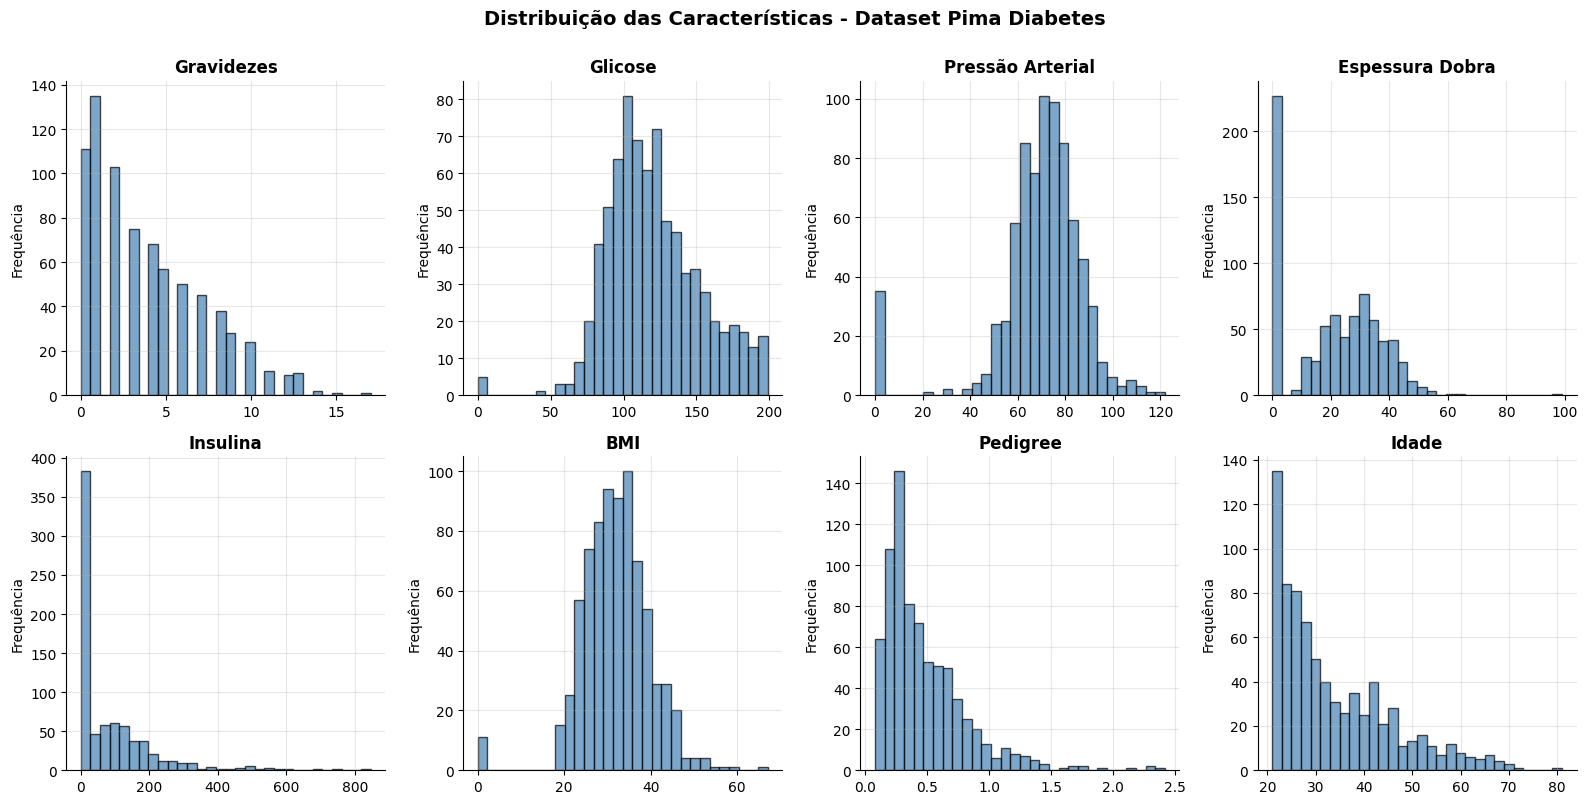

In [3]:
# HISTOGRAMAS DAS CARACTERÍSTICAS DO DATASET

# Nomes das features (correspondentes ao dataset Pima Diabetes)
feature_names_pt = ['Gravidezes', 'Glicose', 'Pressão Arterial', 'Espessura Dobra',
                    'Insulina', 'BMI', 'Pedigree', 'Idade']

# Criar figura com 8 subplots (2 linhas x 4 colunas)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Configurações de cores para os histogramas
colors = ['steelblue', 'steelblue', 'steelblue', 'steelblue','steelblue', 'steelblue', 'steelblue', 'steelblue']

# Criar histogramas para cada feature
for i in range(X.shape[1]):
    axes[i].hist(X[:, i], bins=30, color=colors[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(feature_names_pt[i], fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequência', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Ajustar layout
plt.suptitle('Distribuição das Características - Dataset Pima Diabetes', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


### Desenvolvimento

#### 1. MODELOS DE CLASSIFICAÇÃO

#####  (a) escolher 3 classificadores binários

In [4]:
# Baseado nos slides de Discriminantes Logísticos e sistemas de classificação
# Escolhemos 3 classificadores:

# 1. RandomForestClassifier (obrigatório)
rf = RandomForestClassifier(random_state=42)

# 2. Discriminante Logístico (visto nos slides AA-DiscLogistV2.pdf)
logreg = LogisticRegression(random_state=42, max_iter=1000)

# 3. Naive Bayes Gaussiano (visto nos slides AA-SistClass.pdf)
nb = GaussianNB()

print("Classificadores escolhidos:")
print("1. RandomForestClassifier")
print("2. Logistic Regression (Discriminante Logístico)")
print("3. GaussianNB (Naive Bayes)")
print()

Classificadores escolhidos:
1. RandomForestClassifier
2. Logistic Regression (Discriminante Logístico)
3. GaussianNB (Naive Bayes)



##### (b) Treinar os classificadores - escolha dos hiperparâmetros

In [5]:
# Para o Random Forest, vamos testar diferentes valores de n_estimators
# Baseado no conceito de validação cruzada dos slides AP-Xvalida.pdf

print("Testar hiperparâmetros do RandomForest...")
# Testar diferentes números de árvores
n_trees_options = [10, 50, 100, 200]
best_score = 0
best_n_trees = 10

for n_trees in n_trees_options:
    rf_temp = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(rf_temp, X, y, cv=kfold)
    mean_score = np.mean(scores)
    print(f"  n_estimators={n_trees}, Acurácia média = {mean_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_n_trees = n_trees

print(f"\nMelhor n_estimators: {best_n_trees}\n")

# Atualizar o classificador com o melhor parâmetro
rf = RandomForestClassifier(n_estimators=best_n_trees, random_state=42)

Testar hiperparâmetros do RandomForest...
  n_estimators=10, Acurácia média = 0.7343
  n_estimators=50, Acurácia média = 0.7669
  n_estimators=100, Acurácia média = 0.7695
  n_estimators=200, Acurácia média = 0.7617

Melhor n_estimators: 100



##### (c) Metodologia de treino/teste apropriada

In [6]:
# Baseado nos slides AP-Xvalida.pdf
# Usar StratifiedKFold com 5 folds para manter proporção de classes
# (há desbalanceamento: 500 não-diabetes vs 268 diabetes)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Metodologia escolhida: Stratified K-Fold Cross Validation")
print("Número de folds: 5")
print("Justificação: Mantém a proporção de classes em cada fold,")
print("             importante porque há desbalanceamento nos dados.\n")


# Treinar e obter predições para todos os classificadores
#Utilizar o cross_val_predict treinar o classificador internamente para avaliar com a estratificação, sendo descartado o treino


# Random Forest
print("\n1. RandomForestClassifier:")
scores_rf = cross_val_score(rf, X, y, cv=kfold)
results_rf = cross_val_predict(rf, X, y, cv=kfold)
print(f"   Accuracy por fold: {scores_rf}")
print(f"   Accuracy média: {np.mean(scores_rf):.4f}")

# Logistic Regression
print("\n2. Logistic Regression:")
scores_lr = cross_val_score(logreg, X, y, cv=kfold)
results_lr = cross_val_predict(logreg, X, y, cv=kfold)
print(f"   Accuracy por fold: {scores_lr}")
print(f"   Accuracy média: {np.mean(scores_lr):.4f}")

# Naive Bayes
print("\n3. GaussianNB:")
scores_nb = cross_val_score(nb, X, y, cv=kfold)
results_nb = cross_val_predict(nb, X, y, cv=kfold)
print(f"   Accuracy por fold: {scores_nb}")
print(f"   Accuracy média: {np.mean(scores_nb):.4f}")
print()

Metodologia escolhida: Stratified K-Fold Cross Validation
Número de folds: 5
Justificação: Mantém a proporção de classes em cada fold,
             importante porque há desbalanceamento nos dados.


1. RandomForestClassifier:
   Accuracy por fold: [0.79220779 0.77922078 0.76623377 0.73856209 0.77124183]
   Accuracy média: 0.7695

2. Logistic Regression:
   Accuracy por fold: [0.77922078 0.77922078 0.78571429 0.76470588 0.74509804]
   Accuracy média: 0.7708

3. GaussianNB:
   Accuracy por fold: [0.72077922 0.81818182 0.75974026 0.73856209 0.73856209]
   Accuracy média: 0.7552



##### (d) Métricas apropriadas e calibração


--- RANDOM FOREST ---

Matriz de Confusão:
[[430  70]
 [107 161]]

Relatório de Classificação:
              precision    recall  f1-score   support

Não-Diabetes       0.80      0.86      0.83       500
    Diabetes       0.70      0.60      0.65       268

    accuracy                           0.77       768
   macro avg       0.75      0.73      0.74       768
weighted avg       0.76      0.77      0.77       768


--- LOGISTIC REGRESSION ---

Matriz de Confusão:
[[440  60]
 [116 152]]

Relatório de Classificação:
              precision    recall  f1-score   support

Não-Diabetes       0.79      0.88      0.83       500
    Diabetes       0.72      0.57      0.63       268

    accuracy                           0.77       768
   macro avg       0.75      0.72      0.73       768
weighted avg       0.77      0.77      0.76       768


--- NAIVE BAYES ---

Matriz de Confusão:
[[414  86]
 [102 166]]

Relatório de Classificação:
              precision    recall  f1-score   support


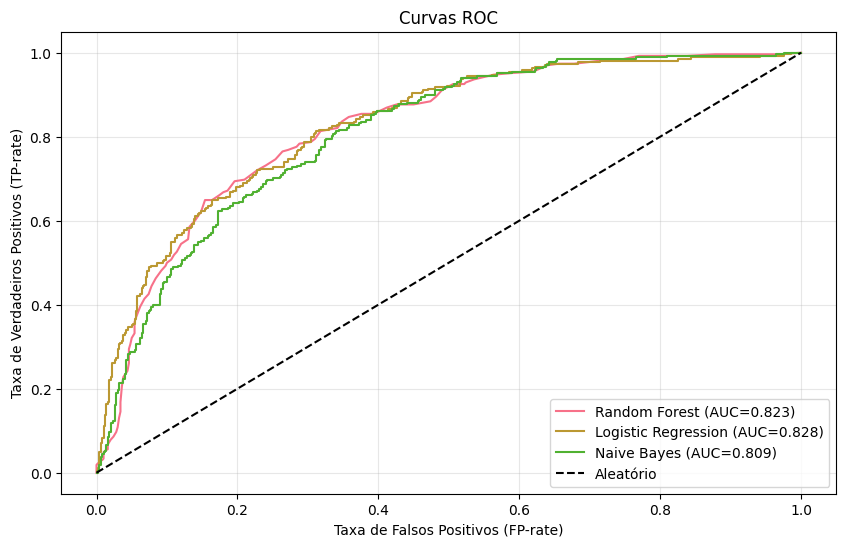

In [7]:
# Baseado nos slides AP-Xvalida.pdf e AA-SistClass.pdf
# Para classificação binária com classes desbalanceadas, usar:
# - Matriz de confusão
# - Precision, Recall, F1-score
# - Curvas ROC e AUC

print("\n--- RANDOM FOREST ---")
print("\nMatriz de Confusão:")
cm_rf = confusion_matrix(y, results_rf)
print(cm_rf)
print("\nRelatório de Classificação:")
print(classification_report(y, results_rf, target_names=['Não-Diabetes', 'Diabetes']))

print("\n--- LOGISTIC REGRESSION ---")
print("\nMatriz de Confusão:")
cm_lr = confusion_matrix(y, results_lr)
print(cm_lr)
print("\nRelatório de Classificação:")
print(classification_report(y, results_lr, target_names=['Não-Diabetes', 'Diabetes']))

print("\n--- NAIVE BAYES ---")
print("\nMatriz de Confusão:")
cm_nb = confusion_matrix(y, results_nb)
print(cm_nb)
print("\nRelatório de Classificação:")
print(classification_report(y, results_nb, target_names=['Não-Diabetes', 'Diabetes']))

# Curvas ROC (baseado nos slides AP-Xvalida.pdf)
print("\nCalculando AUC (Area Under ROC Curve)...")

# Treinar modelos para obter probabilidades (para curvas ROC)
rf_full = RandomForestClassifier(n_estimators=best_n_trees, random_state=42)
rf_full.fit(X, y)
proba_rf = cross_val_predict(rf_full, X, y, cv=kfold, method='predict_proba')[:, 1]

logreg_full = LogisticRegression(random_state=42, max_iter=1000)
logreg_full.fit(X, y)
proba_lr = cross_val_predict(logreg_full, X, y, cv=kfold, method='predict_proba')[:, 1]

nb_full = GaussianNB()
nb_full.fit(X, y)
proba_nb = cross_val_predict(nb_full, X, y, cv=kfold, method='predict_proba')[:, 1]

auc_rf = roc_auc_score(y, proba_rf)
auc_lr = roc_auc_score(y, proba_lr)
auc_nb = roc_auc_score(y, proba_nb)

print(f"AUC - Random Forest: {auc_rf:.4f}")
print(f"AUC - Logistic Regression: {auc_lr:.4f}")
print(f"AUC - Naive Bayes: {auc_nb:.4f}")
print()

# Visualizar curvas ROC
plt.figure(figsize=(10, 6))

fpr_rf, tpr_rf, _ = roc_curve(y, proba_rf)
fpr_lr, tpr_lr, _ = roc_curve(y, proba_lr)
fpr_nb, tpr_nb, _ = roc_curve(y, proba_nb)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC={auc_nb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')

plt.xlabel('Taxa de Falsos Positivos (FP-rate)')
plt.ylabel('Taxa de Verdadeiros Positivos (TP-rate)')
plt.title('Curvas ROC')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Mais Gráficos

### GRÁFICO 1: MATRIZES DE CONFUSÃO VISUALIZADAS

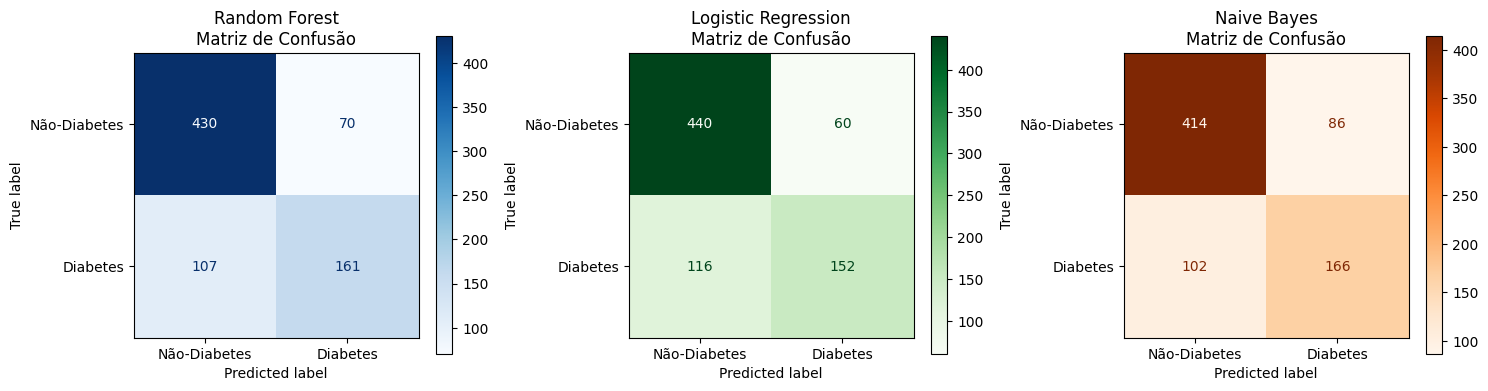

In [8]:
# Treinar modelos para obter probabilidades (para curvas ROC e Precision-Recall)
rf_full = RandomForestClassifier(n_estimators=best_n_trees, random_state=42)
rf_full.fit(X, y)
proba_rf = cross_val_predict(rf_full, X, y, cv=kfold, method='predict_proba')[:, 1]

logreg_full = LogisticRegression(random_state=42, max_iter=1000)
logreg_full.fit(X, y)
proba_lr = cross_val_predict(logreg_full, X, y, cv=kfold, method='predict_proba')[:, 1]

nb_full = GaussianNB()
nb_full.fit(X, y)
proba_nb = cross_val_predict(nb_full, X, y, cv=kfold, method='predict_proba')[:, 1]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Random Forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, 
                                  display_labels=['Não-Diabetes', 'Diabetes'])
disp_rf.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Random Forest\nMatriz de Confusão')
axes[0].grid(False)

# Logistic Regression
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, 
                                  display_labels=['Não-Diabetes', 'Diabetes'])
disp_lr.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Logistic Regression\nMatriz de Confusão')
axes[1].grid(False)

# Naive Bayes
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, 
                                  display_labels=['Não-Diabetes', 'Diabetes'])
disp_nb.plot(ax=axes[2], cmap='Oranges', values_format='d')
axes[2].set_title('Naive Bayes\nMatriz de Confusão')
axes[2].grid(False)

plt.tight_layout()
plt.show()

#### GRÁFICO 2: CURVAS PRECISION-RECALL

Average Precision - Random Forest: 0.6733
Average Precision - Logistic Regression: 0.7096
Average Precision - Naive Bayes: 0.6529


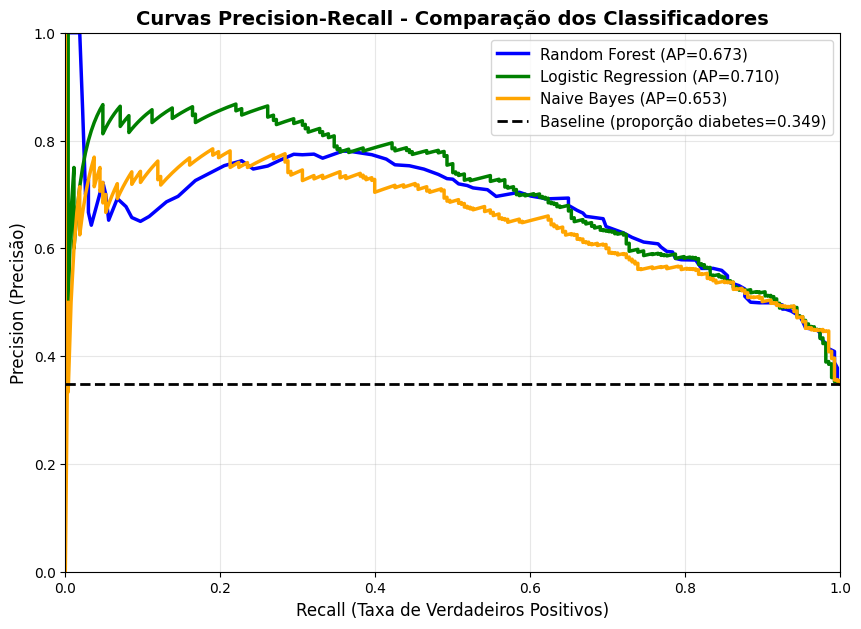

In [9]:
# Calcular curvas Precision-Recall (baseado nos slides AP-Xvalida.pdf)
precision_rf, recall_rf, _ = precision_recall_curve(y, proba_rf)
precision_lr, recall_lr, _ = precision_recall_curve(y, proba_lr)
precision_nb, recall_nb, _ = precision_recall_curve(y, proba_nb)

# Calcular Average Precision Score
ap_rf = average_precision_score(y, proba_rf)
ap_lr = average_precision_score(y, proba_lr)
ap_nb = average_precision_score(y, proba_nb)

print(f"Average Precision - Random Forest: {ap_rf:.4f}")
print(f"Average Precision - Logistic Regression: {ap_lr:.4f}")
print(f"Average Precision - Naive Bayes: {ap_nb:.4f}")

plt.figure(figsize=(10, 7))

plt.plot(recall_rf, precision_rf, 'b-', linewidth=2.5, 
         label=f'Random Forest (AP={ap_rf:.3f})')
plt.plot(recall_lr, precision_lr, 'g-', linewidth=2.5, 
         label=f'Logistic Regression (AP={ap_lr:.3f})')
plt.plot(recall_nb, precision_nb, 'orange', linewidth=2.5, 
         label=f'Naive Bayes (AP={ap_nb:.3f})')

# Linha de baseline (proporção de positivos)
baseline = np.sum(y) / len(y)
plt.axhline(y=baseline, color='k', linestyle='--', linewidth=2, 
            label=f'Baseline (proporção diabetes={baseline:.3f})')

plt.xlabel('Recall (Taxa de Verdadeiros Positivos)', fontsize=12)
plt.ylabel('Precision (Precisão)', fontsize=12)
plt.title('Curvas Precision-Recall - Comparação dos Classificadores', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

#### GRÁFICO 3: COMPARAÇÃO DE MÉTRICAS EM BARRAS

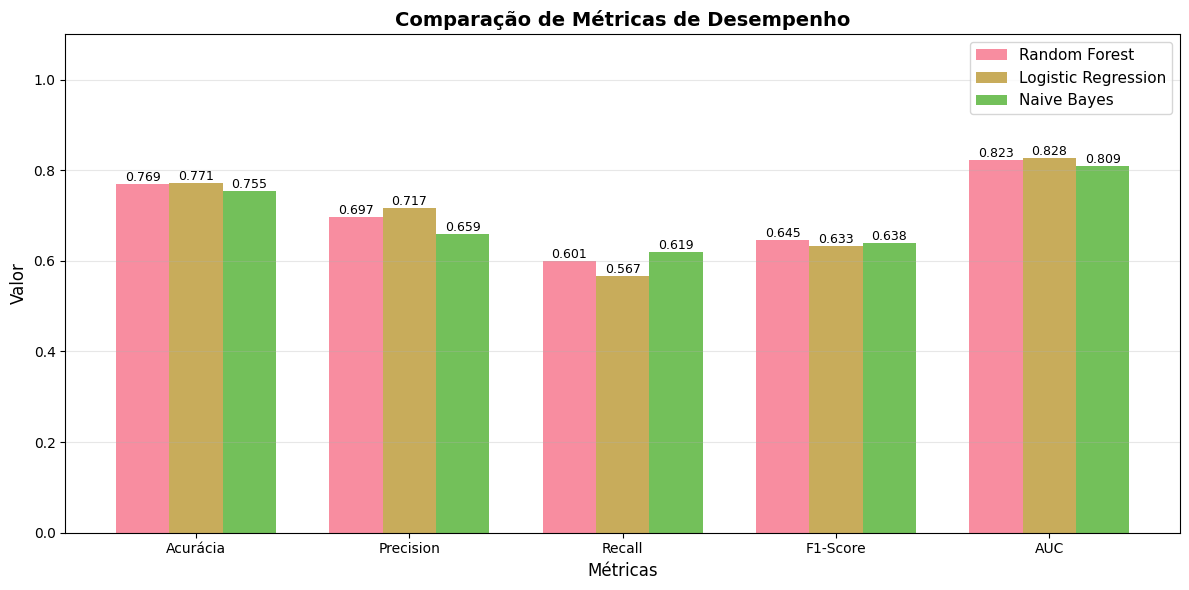

In [10]:
# Extrair métricas dos relatórios
from sklearn.metrics import precision_score, recall_score, f1_score

metrics_data = {
    'Random Forest': {
        'Acurácia': np.mean(scores_rf),
        'Precision': precision_score(y, results_rf),
        'Recall': recall_score(y, results_rf),
        'F1-Score': f1_score(y, results_rf),
        'AUC': auc_rf
    },
    'Logistic Regression': {
        'Acurácia': np.mean(scores_lr),
        'Precision': precision_score(y, results_lr),
        'Recall': recall_score(y, results_lr),
        'F1-Score': f1_score(y, results_lr),
        'AUC': auc_lr
    },
    'Naive Bayes': {
        'Acurácia': np.mean(scores_nb),
        'Precision': precision_score(y, results_nb),
        'Recall': recall_score(y, results_nb),
        'F1-Score': f1_score(y, results_nb),
        'AUC': auc_nb
    }
}

# Criar gráfico de barras agrupadas
metrics_names = ['Acurácia', 'Precision', 'Recall', 'F1-Score', 'AUC']
classifiers = list(metrics_data.keys())

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics_names))
width = 0.25

for i, classifier in enumerate(classifiers):
    values = [metrics_data[classifier][metric] for metric in metrics_names]
    offset = width * (i - 1)
    bars = ax.bar(x + offset, values, width, label=classifier, alpha=0.8)
    
    # Adicionar valores no topo das barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Métricas', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)
ax.set_title('Comparação de Métricas de Desempenho', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

#### GRÁFICO 4: HEATMAP DAS MATRIZES DE CONFUSÃO NORMALIZADAS

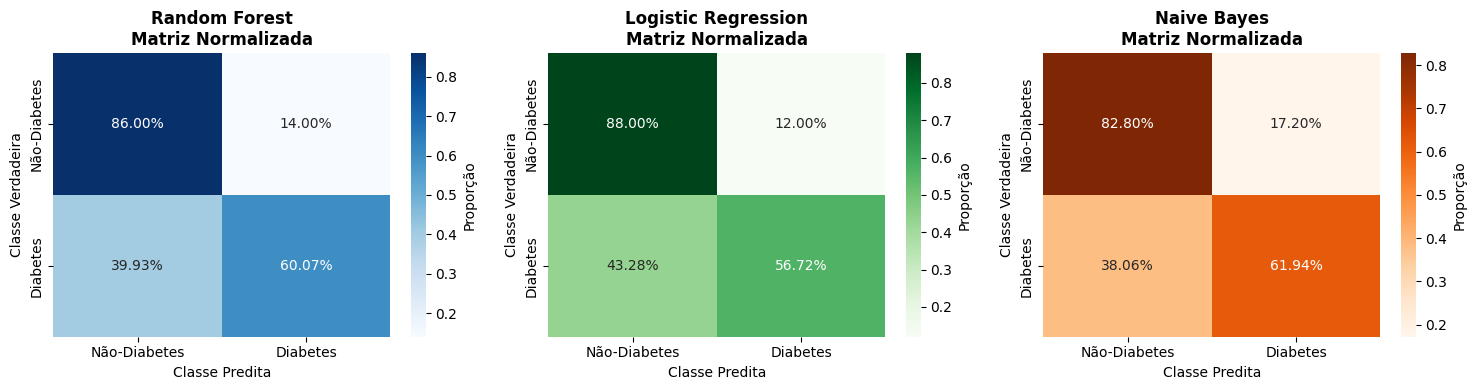

In [11]:
# Normalizar matrizes de confusão
cm_rf_norm = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
cm_lr_norm = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
cm_nb_norm = cm_nb.astype('float') / cm_nb.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Random Forest
sns.heatmap(cm_rf_norm, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Não-Diabetes', 'Diabetes'],
            yticklabels=['Não-Diabetes', 'Diabetes'],
            ax=axes[0], cbar_kws={'label': 'Proporção'})
axes[0].set_title('Random Forest\nMatriz Normalizada', fontweight='bold')
axes[0].set_ylabel('Classe Verdadeira')
axes[0].set_xlabel('Classe Predita')

# Logistic Regression
sns.heatmap(cm_lr_norm, annot=True, fmt='.2%', cmap='Greens', 
            xticklabels=['Não-Diabetes', 'Diabetes'],
            yticklabels=['Não-Diabetes', 'Diabetes'],
            ax=axes[1], cbar_kws={'label': 'Proporção'})
axes[1].set_title('Logistic Regression\nMatriz Normalizada', fontweight='bold')
axes[1].set_ylabel('Classe Verdadeira')
axes[1].set_xlabel('Classe Predita')

# Naive Bayes
sns.heatmap(cm_nb_norm, annot=True, fmt='.2%', cmap='Oranges', 
            xticklabels=['Não-Diabetes', 'Diabetes'],
            yticklabels=['Não-Diabetes', 'Diabetes'],
            ax=axes[2], cbar_kws={'label': 'Proporção'})
axes[2].set_title('Naive Bayes\nMatriz Normalizada', fontweight='bold')
axes[2].set_ylabel('Classe Verdadeira')
axes[2].set_xlabel('Classe Predita')

plt.tight_layout()
plt.show()

##### (e) Estudo comparativo

In [12]:
print("-" * 60)
print(f"{'Classificador':<25} {'accuracy':<12} {'AUC':<12}")
print("-" * 60)
print(f"{'Random Forest':<25} {np.mean(scores_rf):.4f}       {auc_rf:.4f}")
print(f"{'Logistic Regression':<25} {np.mean(scores_lr):.4f}       {auc_lr:.4f}")
print(f"{'Naive Bayes':<25} {np.mean(scores_nb):.4f}       {auc_nb:.4f}")
print("-" * 60)

# Determinar o melhor classificador
best_classifier = None
best_auc = max(auc_rf, auc_lr, auc_nb)

if best_auc == auc_rf:
    best_classifier = "Random Forest"
elif best_auc == auc_lr:
    best_classifier = "Logistic Regression"
else:
    best_classifier = "Naive Bayes"

print(f"\nMelhor classificador (baseado em AUC): {best_classifier}")


------------------------------------------------------------
Classificador             accuracy     AUC         
------------------------------------------------------------
Random Forest             0.7695       0.8230
Logistic Regression       0.7708       0.8278
Naive Bayes               0.7552       0.8092
------------------------------------------------------------

Melhor classificador (baseado em AUC): Logistic Regression


### ANÁLISE:
- A accuracy mede a percentagem total de acertos
- AUC mede a capacidade de discriminar entre classes
- Para dados desbalanceados, AUC é mais informativo que accuracy
- Valores de Recall são importantes em diagnóstico médico
  (evitar falsos negativos - não detetar diabetes quando existe)


### 2. PRÉ-PROCESSAMENTO - NORMALIZAÇÃO

In [13]:
# Baseado nos slides, normalizar significa transformar dados para
# média nula e variância unitária (StandardScaler)

# Normalizar dados
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

#Treinar classificadores com dados normalizados

# Random Forest com dados normalizados
scores_rf_norm = cross_val_score(rf, X_norm, y, cv=kfold)
results_rf_norm = cross_val_predict(rf, X_norm, y, cv=kfold)
proba_rf_norm = cross_val_predict(rf, X_norm, y, cv=kfold, method='predict_proba')[:, 1]
auc_rf_norm = roc_auc_score(y, proba_rf_norm)
ap_rf_norm = average_precision_score(y, proba_rf_norm)

print(f"Random Forest (normalizado): Accuracy = {np.mean(scores_rf_norm):.4f}, AUC = {auc_rf_norm:.4f}, Average Precision={ap_rf_norm:.4f}")

# Logistic Regression com dados normalizados
scores_lr_norm = cross_val_score(logreg, X_norm, y, cv=kfold)
results_lr_norm = cross_val_predict(logreg, X_norm, y, cv=kfold)
proba_lr_norm = cross_val_predict(logreg, X_norm, y, cv=kfold, method='predict_proba')[:, 1]
auc_lr_norm = roc_auc_score(y, proba_lr_norm)
ap_lr_norm = average_precision_score(y, proba_lr_norm)

print(f"Logistic Regression (normalizado): Accuracy = {np.mean(scores_lr_norm):.4f}, AUC = {auc_lr_norm:.4f}, Average Precision={ap_lr_norm:.4f}")

# Naive Bayes com dados normalizados
scores_nb_norm = cross_val_score(nb, X_norm, y, cv=kfold)
results_nb_norm = cross_val_predict(nb, X_norm, y, cv=kfold)
proba_nb_norm = cross_val_predict(nb, X_norm, y, cv=kfold, method='predict_proba')[:, 1]
auc_nb_norm = roc_auc_score(y, proba_nb_norm)
ap_nb_norm = average_precision_score(y, proba_nb_norm)

print(f"Naive Bayes (normalizado): Accuracy = {np.mean(scores_nb_norm):.4f}, AUC = {auc_nb_norm:.4f} , Average Precision={ap_nb_norm:.4f}")
print()



# Comparação
print("COMPARAÇÃO: Dados Originais vs Normalizados")
print("-" * 70)
print(f"{'Classificador':<25} {'Original (AUC)':<20} {'Normalizado (AUC)':<20}")
print("-" * 70)
print(f"{'Random Forest':<25} {auc_rf:.4f}{'':<20}{auc_rf_norm:.4f}")
print(f"{'Logistic Regression':<24} {auc_lr:.4f}{'':<20}{auc_lr_norm:.4f}")
print(f"{'Naive Bayes':<28} {auc_nb:.4f}{'':<20}{auc_nb_norm:.4f}")
print("-" * 70)
print()


Random Forest (normalizado): Accuracy = 0.7721, AUC = 0.8223, Average Precision=0.6727
Logistic Regression (normalizado): Accuracy = 0.7747, AUC = 0.8280, Average Precision=0.7084
Naive Bayes (normalizado): Accuracy = 0.7552, AUC = 0.8092 , Average Precision=0.6529

COMPARAÇÃO: Dados Originais vs Normalizados
----------------------------------------------------------------------
Classificador             Original (AUC)       Normalizado (AUC)   
----------------------------------------------------------------------
Random Forest             0.8230                    0.8223
Logistic Regression      0.8278                    0.8280
Naive Bayes                  0.8092                    0.8092
----------------------------------------------------------------------



### 3. CALIBRAÇÃO DOS MODELOS


 RESULTADOS COM CALIBRAÇÃO
RF (cal): AUC=0.8284, AP=0.6910
LR (cal): AUC=0.8283, AP=0.7098
NB (cal): AUC=0.8097, AP=0.6473


TABELA FINAL
-----------------------------------------------------------------------------------------
Modelo              AUC_NORM       AUC_NORM_CAL   AP_NORM        AP_NORM_CAL    
-----------------------------------------------------------------------------------------
Random Forest       0.8223             0.8284             0.6727             0.6910
Logistic Reg.            0.8280             0.8283             0.7084             0.7098
Naive Bayes            0.8092             0.8097             0.6529             0.6473
-----------------------------------------------------------------------------------------


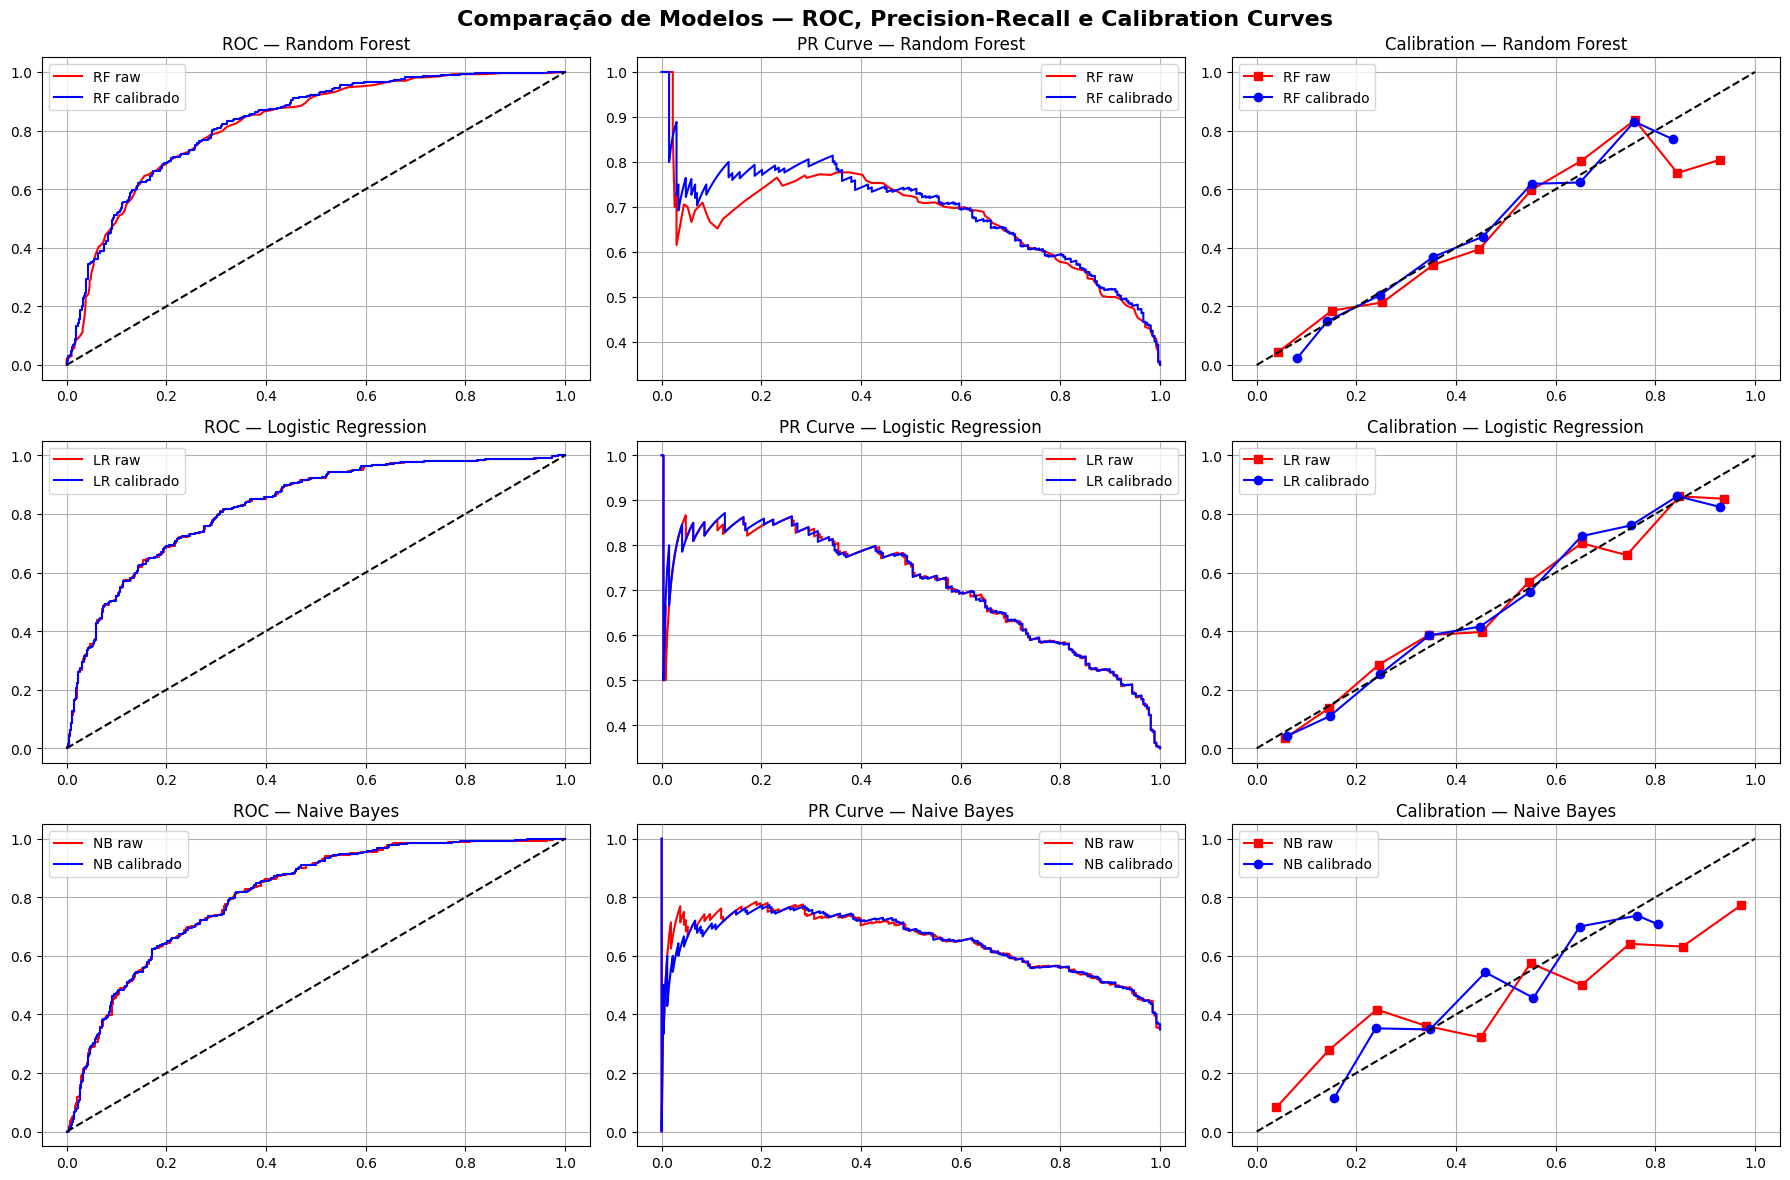

In [14]:
# Calibração com o metodo sigmoid, que é ideal para uma pequena quantidade de dados
#Calibração dos modelos com os dados normalizados

cal_rf_norm = CalibratedClassifierCV(rf, cv=5, method='sigmoid')
cal_proba_rf_norm = cross_val_predict(cal_rf_norm, X_norm, y, cv=kfold, method='predict_proba')[:, 1]
cal_auc_rf_norm = roc_auc_score(y, cal_proba_rf_norm)
cal_ap_rf_norm = average_precision_score(y, cal_proba_rf_norm)

# Logistic Regression com dados normalizados
cal_lr_norm = CalibratedClassifierCV(logreg, cv=5, method='sigmoid')
cal_proba_lr_norm = cross_val_predict(cal_lr_norm, X_norm, y, cv=kfold, method='predict_proba')[:, 1]
cal_auc_lr_norm = roc_auc_score(y, cal_proba_lr_norm)
cal_ap_lr_norm = average_precision_score(y, cal_proba_lr_norm)

# Naive Bayes com dados normalizados
cal_nb_norm = CalibratedClassifierCV(nb, cv=5, method='sigmoid')
cal_proba_nb_norm = cross_val_predict(cal_nb_norm, X_norm, y, cv=kfold, method='predict_proba')[:, 1]
cal_auc_nb_norm = roc_auc_score(y, cal_proba_nb_norm)
cal_ap_nb_norm = average_precision_score(y, cal_proba_nb_norm)

print("\n RESULTADOS COM CALIBRAÇÃO")
print(f"RF (cal): AUC={cal_auc_rf_norm:.4f}, AP={cal_ap_rf_norm:.4f}")
print(f"LR (cal): AUC={cal_auc_lr_norm:.4f}, AP={cal_ap_lr_norm:.4f}")
print(f"NB (cal): AUC={cal_auc_nb_norm:.4f}, AP={cal_ap_nb_norm:.4f}")

print("\n\nTABELA FINAL")
print("-" * 89)
print(f"{'Modelo':<20}{'AUC_NORM':<15}{'AUC_NORM_CAL':<15}{'AP_NORM':<15}{'AP_NORM_CAL':<15}")
print("-" * 89)
print(
    f"{'Random Forest':<20}{auc_rf_norm:.4f}{'':<13}{cal_auc_rf_norm:.4f}{'':<13}{ap_rf_norm:.4f}{'':<13}{cal_ap_rf_norm:.4f}")
print(
    f"{'Logistic Reg.':<25}{auc_lr_norm:.4f}{'':<13}{cal_auc_lr_norm:.4f}{'':<13}{ap_lr_norm:.4f}{'':<13}{cal_ap_lr_norm:.4f}")
print(
    f"{'Naive Bayes':<23}{auc_nb_norm:.4f}{'':<13}{cal_auc_nb_norm:.4f}{'':<13}{ap_nb_norm:.4f}{'':<13}{cal_ap_nb_norm:.4f}")
print("-" * 89)

#   PLOTS PARA OS 3 MODELOS: RF, LR, NB
#   PLOTS: ROC, PR, CALIBRATION
plt.figure(figsize=(18, 12))
plt.suptitle("Comparação de Modelos — ROC, Precision-Recall e Calibration Curves",
             fontsize=16, fontweight='bold')

# 1 — RANDOM FOREST
# ROC
plt.subplot(3, 3, 1)
fpr_raw, tpr_raw, _ = roc_curve(y, proba_rf_norm)
fpr_cal, tpr_cal, _ = roc_curve(y, cal_proba_rf_norm)
plt.plot(fpr_raw, tpr_raw, label="RF raw", color="red")
plt.plot(fpr_cal, tpr_cal, label="RF calibrado", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC — Random Forest")
plt.grid(True)
plt.legend()

# Precision–Recall
plt.subplot(3, 3, 2)
prec_raw, rec_raw, _ = precision_recall_curve(y, proba_rf_norm)
prec_cal, rec_cal, _ = precision_recall_curve(y, cal_proba_rf_norm)
plt.plot(rec_raw, prec_raw, label="RF raw", color="red")
plt.plot(rec_cal, prec_cal, label="RF calibrado", color="blue")
plt.title("PR Curve — Random Forest")
plt.grid(True)
plt.legend()

# Calibration Curve
plt.subplot(3, 3, 3)
pt_raw, pp_raw = calibration_curve(y, proba_rf_norm, n_bins=10)
pt_cal, pp_cal = calibration_curve(y, cal_proba_rf_norm, n_bins=10)
plt.plot(pp_raw, pt_raw, "s-", label="RF raw", color="red")
plt.plot(pp_cal, pt_cal, "o-", label="RF calibrado", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Calibration — Random Forest")
plt.grid(True)
plt.legend()

# 2 — LOGISTIC REGRESSION
# ROC
plt.subplot(3, 3, 4)
fpr_raw, tpr_raw, _ = roc_curve(y, proba_lr_norm)
fpr_cal, tpr_cal, _ = roc_curve(y, cal_proba_lr_norm)
plt.plot(fpr_raw, tpr_raw, label="LR raw", color="red")
plt.plot(fpr_cal, tpr_cal, label="LR calibrado", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC — Logistic Regression")
plt.grid(True)
plt.legend()

# Precision–Recall
plt.subplot(3, 3, 5)
prec_raw, rec_raw, _ = precision_recall_curve(y, proba_lr_norm)
prec_cal, rec_cal, _ = precision_recall_curve(y, cal_proba_lr_norm)
plt.plot(rec_raw, prec_raw, label="LR raw", color="red")
plt.plot(rec_cal, prec_cal, label="LR calibrado", color="blue")
plt.title("PR Curve — Logistic Regression")
plt.grid(True)
plt.legend()

# Calibration Curve
plt.subplot(3, 3, 6)
pt_raw, pp_raw = calibration_curve(y, proba_lr_norm, n_bins=10)
pt_cal, pp_cal = calibration_curve(y, cal_proba_lr_norm, n_bins=10)
plt.plot(pp_raw, pt_raw, "s-", label="LR raw", color="red")
plt.plot(pp_cal, pt_cal, "o-", label="LR calibrado", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Calibration — Logistic Regression")
plt.grid(True)
plt.legend()

# 3 — NAIVE BAYES
# ROC
plt.subplot(3, 3, 7)
fpr_raw, tpr_raw, _ = roc_curve(y, proba_nb_norm)
fpr_cal, tpr_cal, _ = roc_curve(y, cal_proba_nb_norm)
plt.plot(fpr_raw, tpr_raw, label="NB raw", color="red")
plt.plot(fpr_cal, tpr_cal, label="NB calibrado", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC — Naive Bayes")
plt.grid(True)
plt.legend()

# Precision–Recall
plt.subplot(3, 3, 8)
prec_raw, rec_raw, _ = precision_recall_curve(y, proba_nb_norm)
prec_cal, rec_cal, _ = precision_recall_curve(y, cal_proba_nb_norm)
plt.plot(rec_raw, prec_raw, label="NB raw", color="red")
plt.plot(rec_cal, prec_cal, label="NB calibrado", color="blue")
plt.title("PR Curve — Naive Bayes")
plt.grid(True)
plt.legend()

# Calibration Curve
plt.subplot(3, 3, 9)
pt_raw, pp_raw = calibration_curve(y, proba_nb_norm, n_bins=10)
pt_cal, pp_cal = calibration_curve(y, cal_proba_nb_norm, n_bins=10)
plt.plot(pp_raw, pt_raw, "s-", label="NB raw", color="red")
plt.plot(pp_cal, pt_cal, "o-", label="NB calibrado", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Calibration — Naive Bayes")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



 RESULTADOS COM CALIBRAÇÃO
RF (cal): AUC=0.8228, AP=0.6803
LR (cal): AUC=0.8267, AP=0.7039
NB (cal): AUC=0.8087, AP=0.6556


TABELA FINAL
-----------------------------------------------------------------------------------------
Modelo              AUC_NORM       AUC_NORM_CAL   AP_NORM        AP_NORM_CAL    
-----------------------------------------------------------------------------------------
Random Forest       0.8223             0.8228             0.6727             0.6803
Logistic Reg.            0.8280             0.8267             0.7084             0.7039
Naive Bayes            0.8092             0.8087             0.6529             0.6556
-----------------------------------------------------------------------------------------


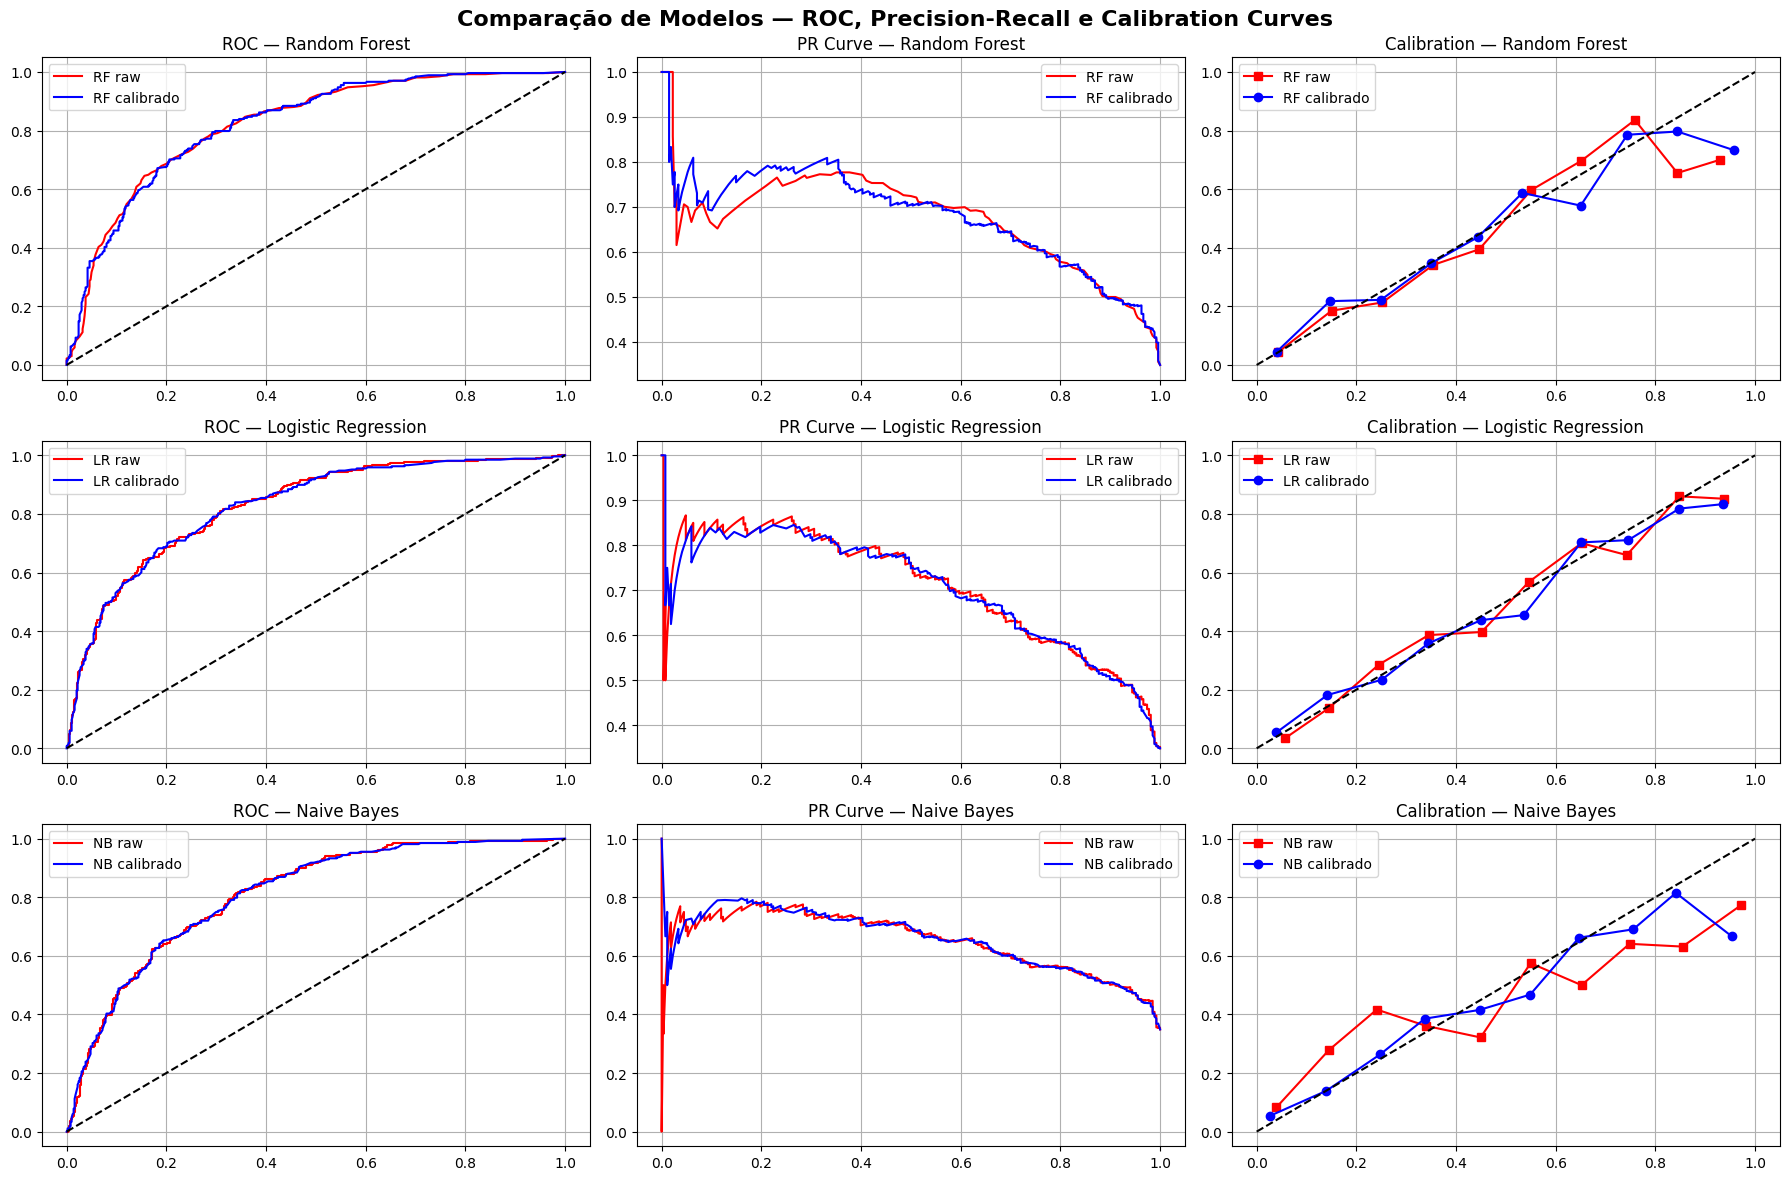

In [15]:
# Calibração com o metodo isotonic, que é ideal para uma  quantidade de dados acima de mil
#Calibração dos modelos com os dados normalizados

cal_rf_norm = CalibratedClassifierCV(rf, cv=5, method='isotonic')
cal_proba_rf_norm = cross_val_predict(cal_rf_norm, X_norm, y, cv=kfold, method='predict_proba')[:, 1]
cal_auc_rf_norm = roc_auc_score(y, cal_proba_rf_norm)
cal_ap_rf_norm = average_precision_score(y, cal_proba_rf_norm)

# Logistic Regression com dados normalizados
cal_lr_norm = CalibratedClassifierCV(logreg, cv=5, method='isotonic')
cal_proba_lr_norm = cross_val_predict(cal_lr_norm, X_norm, y, cv=kfold, method='predict_proba')[:, 1]
cal_auc_lr_norm = roc_auc_score(y, cal_proba_lr_norm)
cal_ap_lr_norm = average_precision_score(y, cal_proba_lr_norm)

# Naive Bayes com dados normalizados
cal_nb_norm = CalibratedClassifierCV(nb, cv=5, method='isotonic')
cal_proba_nb_norm = cross_val_predict(cal_nb_norm, X_norm, y, cv=kfold, method='predict_proba')[:, 1]
cal_auc_nb_norm = roc_auc_score(y, cal_proba_nb_norm)
cal_ap_nb_norm = average_precision_score(y, cal_proba_nb_norm)

print("\n RESULTADOS COM CALIBRAÇÃO")
print(f"RF (cal): AUC={cal_auc_rf_norm:.4f}, AP={cal_ap_rf_norm:.4f}")
print(f"LR (cal): AUC={cal_auc_lr_norm:.4f}, AP={cal_ap_lr_norm:.4f}")
print(f"NB (cal): AUC={cal_auc_nb_norm:.4f}, AP={cal_ap_nb_norm:.4f}")

print("\n\nTABELA FINAL")
print("-" * 89)
print(f"{'Modelo':<20}{'AUC_NORM':<15}{'AUC_NORM_CAL':<15}{'AP_NORM':<15}{'AP_NORM_CAL':<15}")
print("-" * 89)
print(
    f"{'Random Forest':<20}{auc_rf_norm:.4f}{'':<13}{cal_auc_rf_norm:.4f}{'':<13}{ap_rf_norm:.4f}{'':<13}{cal_ap_rf_norm:.4f}")
print(
    f"{'Logistic Reg.':<25}{auc_lr_norm:.4f}{'':<13}{cal_auc_lr_norm:.4f}{'':<13}{ap_lr_norm:.4f}{'':<13}{cal_ap_lr_norm:.4f}")
print(
    f"{'Naive Bayes':<23}{auc_nb_norm:.4f}{'':<13}{cal_auc_nb_norm:.4f}{'':<13}{ap_nb_norm:.4f}{'':<13}{cal_ap_nb_norm:.4f}")
print("-" * 89)

#   PLOTS PARA OS 3 MODELOS: RF, LR, NB
#   PLOTS: ROC, PR, CALIBRATION
plt.figure(figsize=(18, 12))
plt.suptitle("Comparação de Modelos — ROC, Precision-Recall e Calibration Curves",
             fontsize=16, fontweight='bold')

# 1 — RANDOM FOREST
# ROC
plt.subplot(3, 3, 1)
fpr_raw, tpr_raw, _ = roc_curve(y, proba_rf_norm)
fpr_cal, tpr_cal, _ = roc_curve(y, cal_proba_rf_norm)
plt.plot(fpr_raw, tpr_raw, label="RF raw", color="red")
plt.plot(fpr_cal, tpr_cal, label="RF calibrado", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC — Random Forest")
plt.grid(True)
plt.legend()

# Precision–Recall
plt.subplot(3, 3, 2)
prec_raw, rec_raw, _ = precision_recall_curve(y, proba_rf_norm)
prec_cal, rec_cal, _ = precision_recall_curve(y, cal_proba_rf_norm)
plt.plot(rec_raw, prec_raw, label="RF raw", color="red")
plt.plot(rec_cal, prec_cal, label="RF calibrado", color="blue")
plt.title("PR Curve — Random Forest")
plt.grid(True)
plt.legend()

# Calibration Curve
plt.subplot(3, 3, 3)
pt_raw, pp_raw = calibration_curve(y, proba_rf_norm, n_bins=10)
pt_cal, pp_cal = calibration_curve(y, cal_proba_rf_norm, n_bins=10)
plt.plot(pp_raw, pt_raw, "s-", label="RF raw", color="red")
plt.plot(pp_cal, pt_cal, "o-", label="RF calibrado", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Calibration — Random Forest")
plt.grid(True)
plt.legend()

# 2 — LOGISTIC REGRESSION
# ROC
plt.subplot(3, 3, 4)
fpr_raw, tpr_raw, _ = roc_curve(y, proba_lr_norm)
fpr_cal, tpr_cal, _ = roc_curve(y, cal_proba_lr_norm)
plt.plot(fpr_raw, tpr_raw, label="LR raw", color="red")
plt.plot(fpr_cal, tpr_cal, label="LR calibrado", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC — Logistic Regression")
plt.grid(True)
plt.legend()

# Precision–Recall
plt.subplot(3, 3, 5)
prec_raw, rec_raw, _ = precision_recall_curve(y, proba_lr_norm)
prec_cal, rec_cal, _ = precision_recall_curve(y, cal_proba_lr_norm)
plt.plot(rec_raw, prec_raw, label="LR raw", color="red")
plt.plot(rec_cal, prec_cal, label="LR calibrado", color="blue")
plt.title("PR Curve — Logistic Regression")
plt.grid(True)
plt.legend()

# Calibration Curve
plt.subplot(3, 3, 6)
pt_raw, pp_raw = calibration_curve(y, proba_lr_norm, n_bins=10)
pt_cal, pp_cal = calibration_curve(y, cal_proba_lr_norm, n_bins=10)
plt.plot(pp_raw, pt_raw, "s-", label="LR raw", color="red")
plt.plot(pp_cal, pt_cal, "o-", label="LR calibrado", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Calibration — Logistic Regression")
plt.grid(True)
plt.legend()

# 3 — NAIVE BAYES
# ROC
plt.subplot(3, 3, 7)
fpr_raw, tpr_raw, _ = roc_curve(y, proba_nb_norm)
fpr_cal, tpr_cal, _ = roc_curve(y, cal_proba_nb_norm)
plt.plot(fpr_raw, tpr_raw, label="NB raw", color="red")
plt.plot(fpr_cal, tpr_cal, label="NB calibrado", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC — Naive Bayes")
plt.grid(True)
plt.legend()

# Precision–Recall
plt.subplot(3, 3, 8)
prec_raw, rec_raw, _ = precision_recall_curve(y, proba_nb_norm)
prec_cal, rec_cal, _ = precision_recall_curve(y, cal_proba_nb_norm)
plt.plot(rec_raw, prec_raw, label="NB raw", color="red")
plt.plot(rec_cal, prec_cal, label="NB calibrado", color="blue")
plt.title("PR Curve — Naive Bayes")
plt.grid(True)
plt.legend()

# Calibration Curve
plt.subplot(3, 3, 9)
pt_raw, pp_raw = calibration_curve(y, proba_nb_norm, n_bins=10)
pt_cal, pp_cal = calibration_curve(y, cal_proba_nb_norm, n_bins=10)
plt.plot(pp_raw, pt_raw, "s-", label="NB raw", color="red")
plt.plot(pp_cal, pt_cal, "o-", label="NB calibrado", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Calibration — Naive Bayes")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


<h3>Calibração das Probabilidades</h3>

A probabilidade produzida por um classificador nem sempre representa corretamente a realidade.
Modelos como Random Forests, SVMs ou Gradient Boosting tendem a gerar previsões demasiado confiantes, mesmo quando estando erradas.
Para corrigir isso, aplica-se um processo de calibração das probabilidades.


<b>Método Sigmoid (Platt Scaling)</b>
A função sigmoid dada por:
$$ p(x)= \frac{1}{1+e^{A f(x) + B }} $$

- f(x) é o output bruto do modelo antes da calibração
- A e B são parâmetros aprendidos pelo algoritmo
- A sigmoid transforma o output numa probabilidade “corrigida”.
-
Este método tem duas caraterísticas essenciais, onde paramétrico, ou seja, assume uma curva suave em “S”.
Funciona muito bem em datasets pequenos ou médios, como o presente.
Evita overfitting, porque a transformação tem apenas dois parâmetros.
Por isso é especialmente adequado para:
* Random Forests
* SVMs
* Gradient Boosting
* Dados com poucas centenas ou poucos milhares de amostras

<b>Método Isotonic</b>
Quando as probabilidades são muito irregulares, ou quando se tem muitos dados, é comum usar a Regressão Isotónica.
Esta técnica:
* não assume nenhum formato específico para a curva;
* apenas exige que seja monótona crescente;
* ajusta uma função em “degraus”, sendo muito flexível.
No entanto não é aramétrica, ou seja pode adaptar-se demasiado aos dados.
Ainda dá overfit facilmente quando o dataset é pequeno, normalmente só é recomendado quando existem mais de 1000–5000 amostras.

<b>Escolha no contexto deste trabalho</b>

O dataset Pima Diabetes tem apenas 768 amostras, o que é considerado um dataset pequeno.
Por isso:
* O método sigmoid é a escolha correta e mais estável.
* O método isotonic tenderia a overfitar, criando uma curva demasiado ajustada ao conjunto de treino, e poranto exibindo valores maiores

###  3. Observações Gerais:

##### 1. CLASSIFICADORES:
- Melhor desempenho: Logistic Regression
- Todos os modelos têm desempenho razoável (AUC > 0.70)

##### 2. NORMALIZAÇÃO:
- Beneficia classificadores baseados em distância/gradiente
- Random Forest é robusto a diferentes escalas

##### 3. METODOLOGIA:
- Stratified K-Fold garante representatividade das classes
- AUC é métrica mais adequada para dados desbalanceados


##### 4. CALIBRAÇÃO:
- Garante a fildelidade dos valores expostos pelos modelos
- Avaliação após a calibração aumentou, excepto na precisão média do Neyve Bayes

##### 5. CONSIDERAÇÕES MÉDICAS:
- Recall alto é importante (evitar falsos negativos)
- Um falso negativo = não detetar diabetes quando existe
- Pode ser necessário ajustar limiar de decisão


**<center><h1>FIM</h1></center>**